In [2]:
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt

In [3]:
title = "# Introduction"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Introduction

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

# Bayesian Statistical Methods and Data Analysis

- Introductions 
- Logistics
- Structure of the course
- Intro to Python and JupyterHub

## Introductions

## Logistics

Slides and notebooks available on Moodle and [github](https://github.com/tilmantroester/bayesian_statistical_methods/tree/fs24).

Attendance is not required but strongly recommended. I will try to keep a zoom connection open but the plan is to keep the course interactive with a lot of hands-on practice, so attending remotely (or not at all) will probably not be as useful.

### Grades

If you want credit points, the grade is going to be based on a small research project & report.
- The project should either cover a data analysis or the theory behind a statistical tool.
    - This can be one of the project ideas I will suggest throughout the course or some data or algorithm you find interesting and want to explore more, for example from your own research.
- Format: like a journal article (specifically a Letter):
    - Professional presentation, i.e. using LaTeX, nice plots
    - Proper references and appropriate structure
    - Page limit of 5 (excluding references)
    - I will add a good example report on Moodle
- Group work is allowed. Conditions:
    - Max group size: 5
    - Everyone in the group gets the same grade
    - Everyone needs to contribute to both the report and the analysis
    - The report needs to include a contribution statement that briefly describes what each member has done

Deadline is 2024/07/19 at 23:59 CEST.

## Structure of the course

- Lesson, work on exercises, discuss solutions
- To get most out of the course, have a look at the material and exercises **before** the lecture
- Learning by doing: we will implement many of the basic methods ourselves to get an intuition for how they work
    - After that using well-developed and robust libraries is usually preferable


- Working in teams is encouraged
- Be ready for Clicker questions

- Feedback is always welcome!
    - EduApp: Course channel "Feedback"
    - Anonymous Google form (link on Moodle)
    - Email
    - In-person
    - Official course evaluation on the last day of the course: Friday 14 June at 16:00

## What is this course about?

### Statistical inference

Statistical inference is concerned with drawing conclusions from data about quantities that are not observed. 
As a very simple example you could think of an Olympic sprinter and you urgently want to know their average speed. However, you only know the distance and have measured the time, where the measured time is subject to uncertainty. That's your data.

### Bayesian data analysis

Bayesian statistics provides a framework to make inference about the world by combining data with prior knowledge.

The core of Bayesian data analyses is coming up with a probabilistic model of the world. 
These models describe both the observable and unobservable quantities of a problem in probabilistic terms.

#### Examples

Going back to the sprinter example: we do have an idea about running speeds at the Olympics we can use as our prior knowledge.

You might have learned to equip the measured time with an uncertainty and then propagate this error onto the calculated speed. The more elegant and also more flexible, as it isn't limited to Gaussian errors, way of doing this is building a probabilistic model. This way, we can infer a probability distribution for the speed given our measurement of the time $p(v | t)$ and can calculate a probability that the true speed lies in a certain range. 

$t = \frac{d}{v}$ would be your model to connect observed and unobserved quantities but now we build in the uncertainty in $t$ from the measurement, such that $p(t | v) \sim \mathcal{N}(\mu = \frac{d}{v}, \sigma_t^2)$ assuming a normal distribution and a measurement uncertainty on the measured time $\sigma_t$. 
$p(v | t)$ gives us the full probability distribution of the runner's speed, fully taking the uncertainty of our measurement of the time into account, not just a speed with errorbars.


In [10]:
d = 100

def likelihood(v,t):
    sigma_t = 0.5
    mu = d / v
    normal = scipy.stats.norm(mu,sigma_t)
    return normal.pdf(t)

def prior(v):
    p = 1/(v[-1]-v[0])
    return p * np.ones_like(v)  

def posterior(v,t):
    return likelihood(v,t) * prior(v)

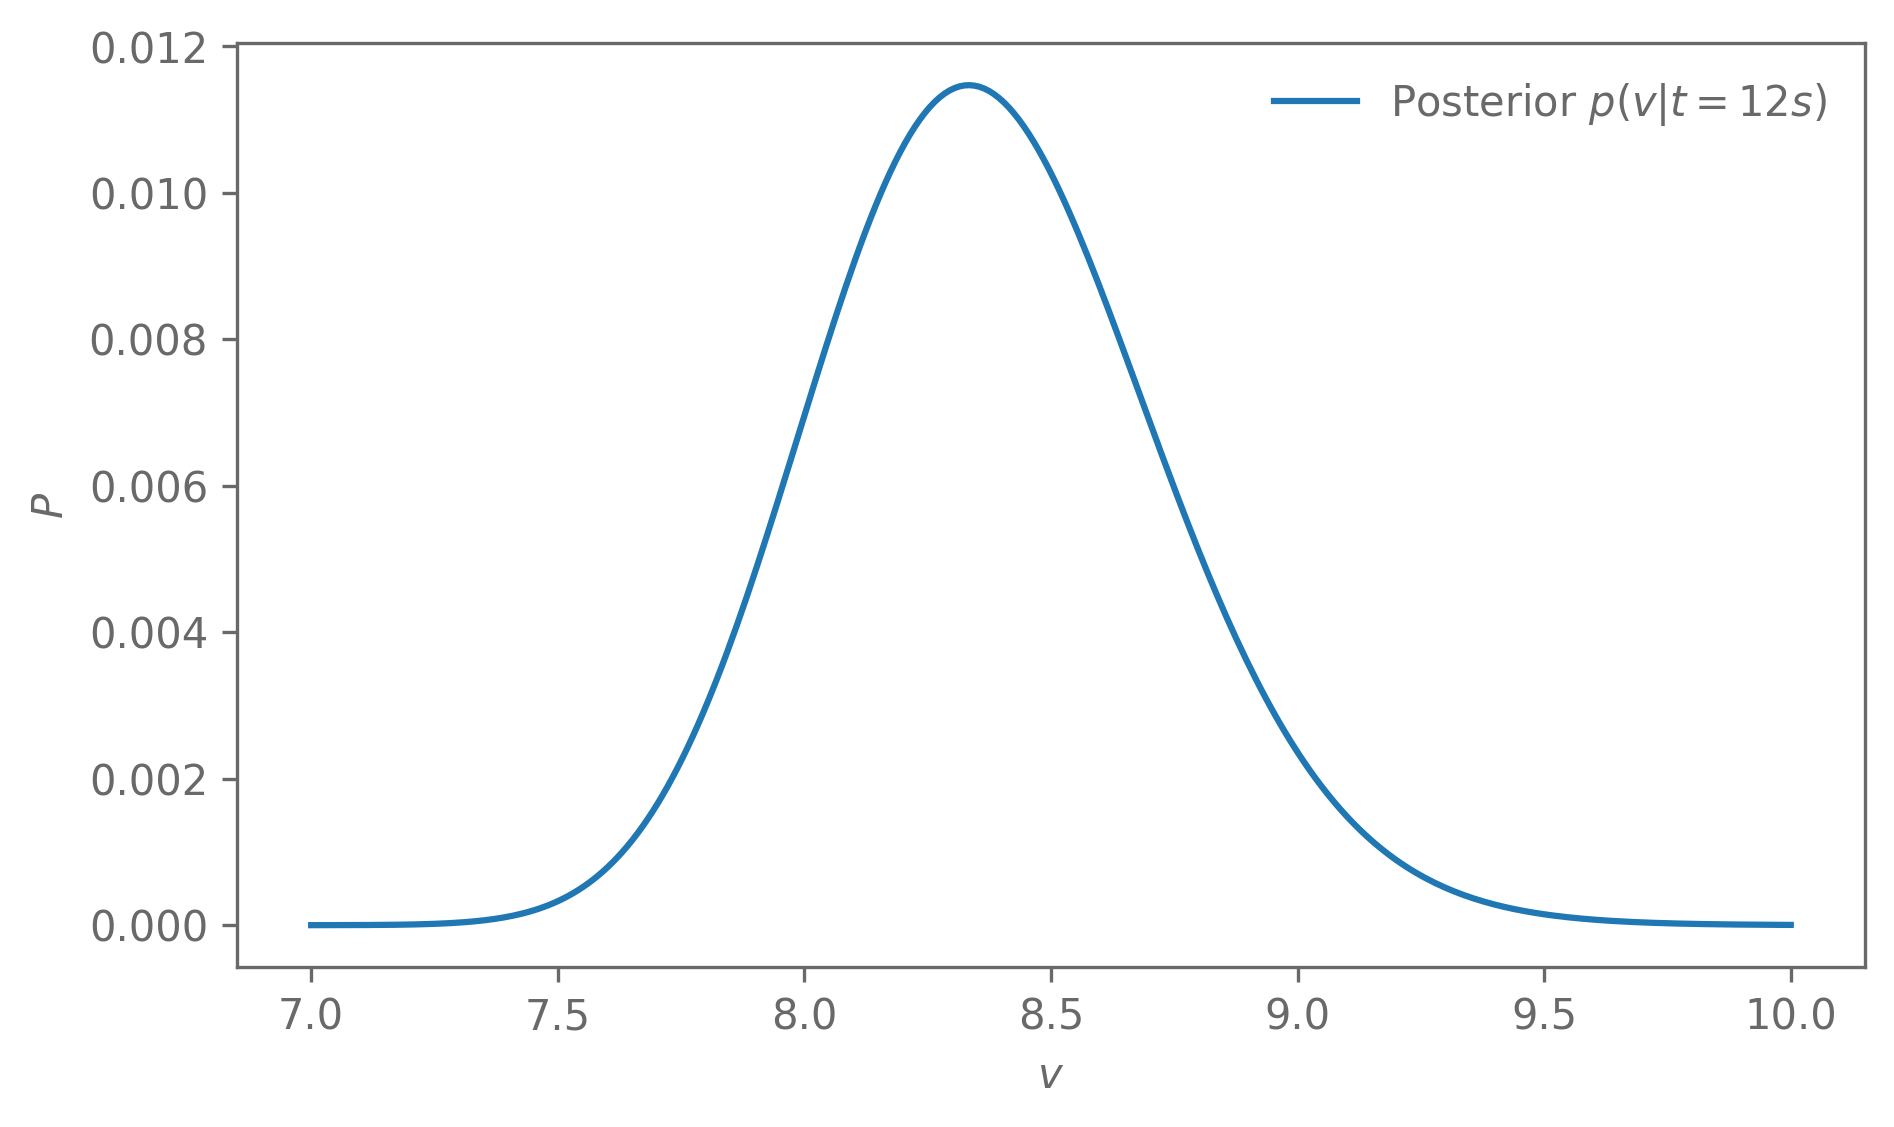

In [11]:
v = np.linspace(7, 10,300)
t = 12
posterior = posterior(v,t)
# Normalise the posterior
posterior /= posterior.sum()

plt.plot(v, posterior, label="Posterior $p(v|t=12s)$")
#plt.plot(v, prior(v), c="grey", ls=":", label="Prior $p(v)$")
plt.legend(frameon=False)
plt.ylabel("$P$")
plt.xlabel("$v$");

Another example one can think of is the weather. Imagine you want to know whether it rains within the next hour. You will never know for sure but you can make a more educated guess by evaluating additional information. You can take data - i.e. are there clouds? What's the current humidity? The windspeed? And you can incorporate prior knowledge such as the number of days a year it usually rains in your area, say $30\%$. 

A weather model could tell you that the humidity is normally distributed around $80\%$ with a standard deviation of $10\%$ the hour before it rains and otherwise around $50\%$ with a standard deviation of $15\%$. The wind speed is distributed as $v \sim \mathcal{N}(\mu = 5 \mathrm{m}/\mathrm{s}, 2 \mathrm{m}/\mathrm{s})$ just before it rains, otherwise $v \sim \mathcal{N}(\mu = 3 \mathrm{m}/\mathrm{s}, 1 \mathrm{m}/\mathrm{s})$ (note the higher variance in the first case, all of this can be built into the model). The chance of you seeing clouds is $80\%$ in the hour before it rains, $30\%$ otherwise. 

Your data (the only thing that is certain) are: 

- Clouds C: Yes
- Humidity H: $75\%$
- Wind Speed W: $4 \mathrm{m}/\mathrm{s}$

Putting all of this together using Bayes theorem (we will get to this next week), you can deduce the probability for rain in the next hour:

$P(\text{Rain} \mid C, H, W) = \frac{P(C, H, W \mid \text{Rain}) \cdot P(\text{Rain})}{P(C, H, W)}$

with

$P(C, H, W \mid \text{Rain}) = 0.8 \times \frac{1}{\sqrt{2\pi(10^2)}} \exp\left( -\frac{(75 - 80)^2}{2(10^2)} \right) \times \frac{1}{\sqrt{2\pi(2^2)}} \exp\left( -\frac{(4 - 5)^2}{2(2^2)} \right)$ 

and $P(\text{Rain}) = 0.3$.

$P(\text{Rain} \mid C, H, W) \approx 0.89$

Clicker question: 

Note that we didn't put any exact numbers except for the measured data, everything else was just probability distributions. 

### Bayesian workflow
#### 1. Build a model
- The model should describe the data-generating process that gave rise to the observed data. 
- For example, not only predict the mean, but also the uncertainty in the data.

#### 2. Fit the model to the data
- Condition our probabilistic model on the observed data 
- Obtain the posterior distribution: the probability distribution of the unobserved quantities of interest

#### 3. Check the model
- Do the results make sense?
- Could our model have produced data like those we have observed?
- If not, go back to step 1.

#### Think in distributions

In Bayesian statistics, the only thing that is exactly known are the observed data, everything else is uncertain.
To capture the complete uncertainty structure, we work with probability distributions.



### Computational statistics

Outside of simple models and special cases, our models will likely rely on numerical methods. 
This is especially the case in Bayesian data analysis, where drawing samples from complex distributions is often a key part of the analysis.

#### Monte-Carlo simulation

Once our models become complex, there are usually no analytic solutions any more. 
But we can often still _simulate_ the model and work with the simulated output to make inferences.

Much of statistical inference is about evaluating integrals. Usual integration routines do not work most of the time. For example, because the dimensionality is too high, the boundary conditions are complicated, or we cannot evaluate the integrands explicitly.

Using Monto-Carlo sampling, these problems can often be solved. 

## Literature

- Practical Statistics for Astronomers, Wall, 2012 [ETH library](https://eth.swisscovery.slsp.ch/permalink/41SLSP_ETH/lshl64/alma99117170816205503). Short, with a focus on practical applications. Many of the examples and exercises are from astrophysics but are generally applicable, especially for the physical sciences, which often come a bit short in general statistics textbooks. Solutions and data sets are [available online](https://www.astro.ubc.ca/people/jvw/ASTROSTATS/pracstats_web_ed2.html).
- Bayesian Data Analysis, Gelman, 2013 [ETH library](https://eth.swisscovery.slsp.ch/permalink/41SLSP_ETH/lshl64/alma99117222397805503), [Link](http://www.stat.columbia.edu/~gelman/book/). The title says it all.
- Information Theory, Inference, and Learning Algorithms, MacKay, 2003 [Link](http://www.inference.org.uk/itprnn/book.pdf). Heavy on the information theory but also covers inference methods nicely. The exercises come with solutions.
- Weighing the odds, a course in probability and statistics, Williams, 2001 [ETH library](https://eth.swisscovery.slsp.ch/permalink/41SLSP_ETH/lshl64/alma99117170967205503). A good introduction to probability theory and statistics with a high level of mathematical rigour.


## Python, Jupyter notebooks, and JupyterLab

The course focusses on computational methods to do data analysis with Bayesian statistics.

We will be using Python. There are other options, such as R and Julia, but once the models become more complex, Python has a much larger ecosystem available. 
For example astrophysics software or deep learning libraries.



### Jupyter notebooks

A key part of a statistical analysis is understanding your data.
Data exploration and visualisation is made easy by using Jupyter notebooks, which allow combining code, visualisations, and documentation in one place. 

They are not good for complex modelling however. Once your code goes beyond some simple data analysis and plotting, splitting the modelling code into standalone modules and packages makes things more robust and maintainable.



### JupyterLab

[JupyterLab](https://jupyterlab.readthedocs.io) is an environment that centres around editing notebooks in your browser but can do a lot more as well. For example, it provides debugging and version control interfaces, access to a terminal, etc. 

ETH provides an instance of JupyterLab for everyone in the course. 
This is an online development environment and comes with all the necessary packages installed. 
Changes you make will persist throughout the course. 
If you set up version control, it is easy to synchronise your JupyterLab instance with a local copy on your own device. 

You are free to use your own setup as well.

#### Using JupyterLab

If you are seeing this in the course JupyterLab, you are probably in the directory with the course materials:

<img src="../assets/jupyterlab_landing.png" height="200">

To make your life easier later on with version control, go up one level in the directory structure and make your own directory for the code you are going to write in this course:

<img src="../assets/jupyterlab_toplevel_annotated.png" height="400">

#### On your own device

All the materials can be access outside of JupyterLab as well. The repository with the course materials can be found [on github](https://github.com/tilmantroester/bayesian_statistical_methods/tree/fs2023).

To set up your own computing environment I strongly recommend anaconda. Either using [miniconda](https://docs.conda.io/en/latest/miniconda.html) or the much faster [mamba](https://mamba.readthedocs.io/en/latest/installation.html#install-script) implementation.

### Useful extensions

Two very useful JupyterLab extensions are enabled on the ETH instance: debugging and version control with git.


#### Debugging

Any code ever written has bugs. Do not trust anyone that claims their code does not contain bugs. That includes yourself!

A common approach to debugging is the sprinkle `print` statements throughout the code and try to figure out when something does not work as it should.

What are some reasons why this approach might be sub optimal?

The alternative is using a debugger.

A debugger allows to
- Step through a program line-by-line
- Set breakpoints, so the execution automatically pauses when reaching the breakpoint
- Inspect the values of variables while the program is running and evaluate expressions based on them

One of the biggest downsides to using debugger used to be the set up. But JupyterLab allows [debugging](https://jupyterlab.readthedocs.io/en/latest/user/debugger.html
) of notebook cells, without having to setup `pdb`, `gdb`, etc. 

Debuggers built into other tools, such as [VS Code](https://code.visualstudio.com/), are even more powerful, with features such as [conditional breakpoints](https://code.visualstudio.com/Docs/editor/debugging#_advanced-breakpoint-topics).


![jupyterlab debugger](../assets/jupyterlab_debug_annotated.png)


#### Version control

If you are already familiar with version control and git, great! If not and your version control looks something like

- `my_great_research_project.py`
- `my_great_research_project_ver2.py`
- `my_great_research_project_ver3.py`
- `my_great_research_project_final.py`
- `my_great_research_project_really_final.py`
- `my_great_research_project_really_really_final.py`

I suggest [this introduction](https://learn.microsoft.com/en-us/training/paths/intro-to-vc-git/). Knowing how to use version control like git is essential if you work on code (or reports) together with other people. 



To use git on JupyterLab you can use either the command line interface by opening a terminal or the graphical interface provided by JupyterLab:

- Clone an existing repository:
    1. Create a repository on your provider of choice (github, gitlab, bitbucket, etc)
    2. On JupyterLab, `Git->Clone a Repository`. 
- Initialise an empty repository on JupyterLab:
    1. `Git->Initialize a Repository`
    2. If you want to synchronise with a repository outside of JupyterLab, add the remote: `Git->Manage Remote Repositories`

Once the repository is set up on JupyterLab, you can add files by right-clicking on it and selecting `Git->Add` from the context menu.

Opening the git pane on the left allows you to see the files with changes, look at the diffs, stage/unstage files, and commit the changes.


![git interface](../assets/jupyterlab_git_annotated.png)

### Exercise

1. Create a new directory at the top of the JupyterLab file system
2. Create a new Python notebook

3. Obtain an estimate of the value of $\pi$
    - From the definition in `numpy`
    - Using an analytic series expansion: $\pi = 4 \sum_{k=0}^\infty \frac{(-1)^{k}}{2k + 1}$
    - Using a Monte-Carlo estimate: 
        1. Sample $n$ points uniformly on the unit square using `numpy.random.uniform`
        2. Count the number $n_{<r}$ of points with distance $r = \sqrt{x^2+y^2} \leq 1$
        3. Compare the fraction $\frac{n_{<r}}{n}$ to the ratio of the area of a quadrant of a disc to the area of the square to derive an estimate of $\pi$
    - Bonus: Repeat for (hyper) cube and (hyper) ball in 3 or more dimensions. How does the number of samples required to get a robust estimate of $\pi$ change with the number of dimensions? 

4. Use the debugger to step through some iterations of your code.

5. Create plots showing the estimated value as the number of terms in the series expansion and the number of Monte-Carlo samples is varied

## Your python package

The goal of this course is for you to build a toolbox with statistical and computational methods that you can use in your future data analyses. 

For that toolbox to be useful it needs to contain reusable code. Notebooks are great for quick development and data exploration but terrible for reusable and maintainable code. 
As soon as you think about copy & pasting some piece of code from one notebook to another (or within the same notebook), you should instead consider putting that piece of code into your toolbox. 

This toolbox can be made into a python package, so that you can import it where ever you need it.


For example, under `course_tools` in the course repository is a small python package with some helper functions, for example for creating the slides. 

The package can be installed from the `course_tools` directory by calling `pip install --user --editable .`

I can then `import` the package like any other python package and use it


In [1]:
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.load_tex_defs()

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

To create your own package, have a look at the example in `course_tools` and the documentation at https://packaging.python.org/en/latest/tutorials/packaging-projects/.

The key files are
- The `pyproject.toml` file, which specifies that this is a python package
- The `src/bayesian_stats_course_tools/__init__.py`, which makes `bayesian_stats_course_tools` a python module that can be imported.